# CNN Model to classify a disease based on the chest x-ray

In [83]:
#importing the necessary libraries
import numpy as np
from numpy import asarray
from array import *

import pandas as pd
import os
import matplotlib.pyplot as plt

import cv2

from itertools import chain
#from PIL import Image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale, label_binarize
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
#from scipy.misc import imread

%matplotlib inline

In [3]:
#set the plot parameters
plt.rcParams["font.size"] = 30
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.titlesize'] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 10
plt.gray()

<Figure size 864x576 with 0 Axes>

In [4]:
#set the file names for the data - update as needed
data_entry_file_name = "Data_Entry_2017.csv"
#bbox_list_file_name = "BBox_List_2017.csv"
data_entry_df  = pd.read_csv(data_entry_file_name)
#bbox_df = pd.read_csv(bbox_list_file_name)

In [5]:
data_entry_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


It seems that there are a lot of multi-labeled data in our diagnosis. Later we will have to map it out in its separate label so that our model can use it.

In [6]:
data_entry_df['Finding Labels'].value_counts()

No Finding                                                        60361
Infiltration                                                       9547
Atelectasis                                                        4215
Effusion                                                           3955
Nodule                                                             2705
                                                                  ...  
Emphysema|Infiltration|Mass|Nodule|Pleural_Thickening                 1
Infiltration|Mass|Nodule|Pleural_Thickening|Effusion|Pneumonia        1
Emphysema|Pneumothorax|Pneumonia                                      1
Atelectasis|Edema|Effusion|Infiltration|Pleural_Thickening            1
Atelectasis|Consolidation|Mass|Pleural_Thickening                     1
Name: Finding Labels, Length: 836, dtype: int64

In [8]:
data_entry_df[data_entry_df['Patient Age']== 91]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
230,00000049_000.png,Nodule,0,49,91,F,PA,2650,2465,0.143,0.143
581,00000143_005.png,No Finding,5,143,91,M,PA,2500,2048,0.168,0.168
585,00000143_009.png,Atelectasis,9,143,91,M,PA,2992,2991,0.143,0.143
587,00000143_011.png,Atelectasis,11,143,91,M,PA,2992,2991,0.143,0.143
3973,00001085_001.png,Fibrosis|Infiltration|Mass|Pleural_Thickening,1,1085,91,M,PA,2048,2500,0.168,0.168
17750,00004801_001.png,Nodule,1,4801,91,M,PA,2992,2991,0.143,0.143
20851,00005566_012.png,Mass|Pleural_Thickening,12,5566,91,M,PA,2992,2991,0.143,0.143
24615,00006473_000.png,No Finding,0,6473,91,F,PA,2048,2500,0.168,0.168
24616,00006473_001.png,No Finding,1,6473,91,F,PA,2048,2500,0.168,0.168
96724,00025496_000.png,Effusion|Pleural_Thickening,0,25496,91,M,PA,2992,2991,0.143,0.143


In [18]:
image_names_X = data_entry_df['Image Index'][:662]

In [19]:
image_names_X

0      00000001_000.png
1      00000001_001.png
2      00000001_002.png
3      00000002_000.png
4      00000003_000.png
             ...       
657    00000172_000.png
658    00000172_001.png
659    00000172_002.png
660    00000172_003.png
661    00000172_004.png
Name: Image Index, Length: 662, dtype: object

In [25]:
home_path = os.path.expanduser('~')
git_dir = os.path.join(home_path, "Documents\\WFT\\DataScience\\Git") #for Murad
#git_dir = os.path.join(home_path, "Documents/GitHub") #for Sergazy
nih_dir = os.path.join(git_dir, "NIH-CHEST-XRAY")
data_dir = os.path.join(nih_dir, "data")

#the data is so large that the steps crash, so I created a separate images folder
#with just a few images, so change the join statements accordingly

images_dir = os.path.join(data_dir, "images") #for Murad

X_images_names_list = []
for name in image_names_X:
    #line = line.rstrip("\n")
    #print(type(line))
    full_file_dir = os.path.join(images_dir, name)
    X_images_names_list.append(full_file_dir)
X_images_names_list

['C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000001_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000001_001.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000001_002.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000002_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000003_000.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000003_001.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000003_002.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000003_003.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\data\\images\\00000003_004.png',
 'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\

In [26]:
#let's make a list of images for the training images that we can refer later 
#X_images_list = []
X_images_data_list = []

for im_index in range(len(X_images_names_list)):
    tempimg = cv2.imread(X_images_names_list[im_index], 0)
    #X_images_list.append(tempimg)
    temp_array = np.asarray(tempimg)

    temp_array = temp_array.reshape(1,1048576).tolist()
    X_images_data_list.append(temp_array[0])

X_images_data_list=np.asarray(X_images_data_list)

In [28]:
X_images_data_list
X_images_data_list.shape

(662, 1048576)

In [29]:
#data_entry_df['Finding Labels'] = data_entry_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*data_entry_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
len(all_labels)
for current_label in all_labels:
    #if we find a non-empty label, map it to a separate column with a value '1' and leave '0' for the ones not found
    #so in the end we have an encoded array
    if(len(current_label)>1):
        data_entry_df[current_label] = data_entry_df['Finding Labels'].map(lambda found: 1 if current_label in found else 0)
#data_entry_df.sample(25)

diseases_df = data_entry_df[['Image Index','Effusion','Atelectasis','Cardiomegaly','Consolidation','Edema', 
                         'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration','Mass', 'Nodule', 'No Finding',
                          'Pleural_Thickening', 'Pneumonia','Pneumothorax'
                         ]]
#diseases_df



In [32]:
diseases_df

,Image Index,Effusion,Atelectasis,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,No Finding,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [34]:
Y_df = diseases_df.iloc[:662,1:].values.tolist()
Y_df

[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [72]:
Y = np.asarray(Y_df)
Y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [64]:
(X_images_data_list.shape, Y_data.shape)


1048576

In [ ]:
n_diseases = len(set(data_entry_df['Finding Labels']))
n_diseases

In [67]:
X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_images_data_list)
X

array([[0.79215686, 0.78039216, 0.76470588, ..., 0.        , 0.        ,
        0.        ],
       [0.81568627, 0.80392157, 0.80784314, ..., 0.        , 0.        ,
        0.        ],
       [0.02745098, 0.03921569, 0.03529412, ..., 0.05490196, 0.05882353,
        0.03543307],
       ...,
       [0.91764706, 0.91372549, 0.9254902 , ..., 0.17647059, 0.16862745,
        0.08267717],
       [0.        , 0.        , 0.        , ..., 0.28235294, 0.29803922,
        0.14173228],
       [0.02745098, 0.02745098, 0.02745098, ..., 0.02352941, 0.02745098,
        0.02755906]])

In [69]:
n_samples, n_features = X.shape

In [70]:
train_size = int(0.7*len(X))
train_size
test_size = (n_samples-train_size)//2
test_size

99

In [73]:
X_train = X[:train_size]
X_valid = X[train_size:-test_size]
X_test = X[-test_size:]

Y_train = Y[:train_size]
Y_valid = Y[train_size:-test_size]
Y_test = Y[-test_size:]

In [74]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((463, 1048576), (463, 15), (100, 1048576), (100, 15), (99, 1048576), (99, 15))

In [75]:
n_width, n_length = 1024, 1024

In [76]:
# We need to convert the input into (samples, channels, rows, cols) format
X_train = X_train.reshape(X_train.shape[0], 1, n_width, n_length).astype('float32')
X_valid = X_valid.reshape(X_valid.shape[0], 1, n_width, n_length).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, n_width, n_length).astype('float32')
X_train.shape, X_valid.shape, X_test.shape

((463, 1, 1024, 1024), (100, 1, 1024, 1024), (99, 1, 1024, 1024))

In [80]:
import tensorflow as tf
#tf.VERSION
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [77]:
# create model
cnn_model_1 = Sequential()

# 1st Convolution layer
cnn_model_1.add(Conv2D(32, kernel_size=(5,5),
                       data_format="channels_first",
                       input_shape=(1, n_width, n_width), 
                       activation='relu'))

# Max-Pooling
cnn_model_1.add(MaxPooling2D(pool_size=(2,2)))

# Dropout
cnn_model_1.add(Dropout(0.2))

# Flatten
cnn_model_1.add(Flatten())

# 1st Dense layer
cnn_model_1.add(Dense(128, activation='relu'))

# final softmax layer
cnn_model_1.add(Dense(n_digits, activation='softmax'))

# print a summary and check if you created the network you intended
cnn_model_1.summary()

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'experimental_list_devices'

In [53]:
# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X_images_data_list, Y_data)
ranking = rfe.ranking_
ranking

ValueError: bad input shape (662, 15)

Let's see if we can read some of the x-ray images

In [9]:
#setting up the directory to for all the data - modify for your environment
home_path = os.path.expanduser('~')
git_dir = os.path.join(home_path, "Documents\\WFT\\DataScience\\Git") #for Murad
#git_dir = os.path.join(home_path, "Documents/GitHub") #for Sergazy
nih_dir = os.path.join(git_dir, "NIH-CHEST-XRAY")
data_dir = os.path.join(nih_dir, "data")

#the data is so large that the steps crash, so I created a separate images folder
#with just a few images, so change the join statements accordingly

images_dir = os.path.join(nih_dir, "images") #for Murad
#images_dir = os.path.join(data_dir, "images") #for Murad

#remove the -demo from the filename to run on the whole dataset
train_val_imagelist_file = os.path.join(data_dir, "train_val_list-demo.txt")
#train_val_imagelist_file = os.path.join(data_dir, "train_val_list.txt")

#images_001_dir = os.path.join(nih_dir, "images") #for Sergazy


In [10]:
#Read the text file with the names with the images for training 
train_images_names_list = []
train_val_file = open(train_val_imagelist_file , 'r')
for line in train_val_file:
    line = line.rstrip("\n")
    #print(type(line))
    file_loc = os.path.join(images_dir, line)
    train_images_names_list.append(file_loc)
    #print(images_001_list)
train_val_file.close()

In [11]:
train_images_names_list[16]
#00000008_001.png
#00000008_001.png

'C:\\Users\\e206141\\Documents\\WFT\\DataScience\\Git\\NIH-CHEST-XRAY\\images\\00000008_001.png'

In [12]:
#let's make a list of images for the training images that we can refer later 
train_images_list = []
train_images_data_list = []

for im_index in range(len(train_images_names_list)):
    tempimg = cv2.imread(train_images_names_list[im_index], 0)
    train_images_list.append(tempimg)
    temp_array = np.asarray(tempimg)

    temp_array = temp_array.reshape(1,1048576).tolist()
    train_images_data_list.append(temp_array[0])

train_images_data_list=np.asarray(train_images_data_list)

In [13]:
train_images_data_list.shape

(662, 1048576)

[ 6  8  8 ...  9 10  7]


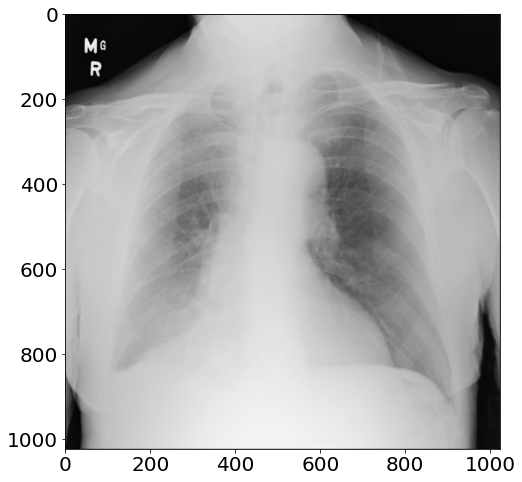

In [19]:
#first image in our list - feel free to change index to see other images
i=34
plt.imshow(train_images_list[i]);
print(train_images_data_list[i])

In [15]:
#and here is our image shaped into an array to feed our network
len(train_images_data_list)

662

In [20]:
train_images_data_list.shape
#resizing of the images
#image_orig_1.size
#width, height = image_orig_1.size  

#newsize = (int(width/4), int(height/4))
#im1 = image_orig_1.resize(newsize) 
#plt.imshow(im1, cmap='gray')

(662, 1048576)

In [23]:
X =  data_entry_df['Image Index'][:662]
X

0      00000001_000.png
1      00000001_001.png
2      00000001_002.png
3      00000002_000.png
4      00000003_000.png
             ...       
657    00000172_000.png
658    00000172_001.png
659    00000172_002.png
660    00000172_003.png
661    00000172_004.png
Name: Image Index, Length: 662, dtype: object

In [198]:
df_Y = pd.DataFrame(Y, columns=["target"])

array([194, 189, 181, ...,   7,   0,   0], dtype=uint8)

In [210]:
X_train = []
for i in range(len(X)):
    temp_list = X[i][0]
    new_list
    j = [j for j in temp_list]
    #for j in rang
    #temp = X[i][0]
    print(temp.type())
    #temp=temp.reshape(1,65536)
    X_train.append(temp)
#X_train = [x for x in X_train]
#X_train

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [186]:
#patient_set = set(data_entry_df['Patient ID'])
#len(patient_set)

In [35]:
data_entry_df['Finding Labels']

0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 112120, dtype: object

In [37]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
7110,00001881_000.png,No Finding,0,1881,36,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
22608,00005986_015.png,Pneumothorax,15,5986,33,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,1
8567,00002268_000.png,No Finding,0,2268,59,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
51224,00012935_021.png,Consolidation|Infiltration|Mass,21,12935,55,M,AP,2500,2048,0.168,...,0,0,0,1,1,0,0,0,0,0
33007,00008646_000.png,No Finding,0,8646,40,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
46447,00011870_001.png,No Finding,1,11870,46,F,AP,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
75509,00018530_001.png,No Finding,1,18530,49,F,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0
23881,00006296_025.png,Infiltration,25,6296,15,F,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,0,0
100981,00026818_016.png,Infiltration,16,26818,31,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,0,0
61741,00015255_014.png,No Finding,14,15255,46,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


,Image Index,Effusion,Atelectasis,Cardiomegaly,Consolidation,Edema,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,No Finding,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [269]:
df_Y["Target"]

KeyError: 'Target'

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from PIL import Image

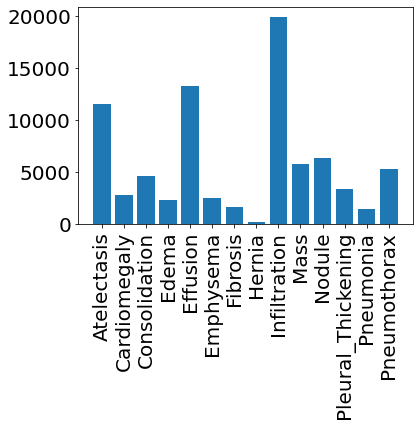

In [139]:
disease_counts = []

for l in all_labels:
    tempcount = (diseases_df[l] != 0).sum()
    disease_counts.append(tempcount)
    
diseases_counts_combined_df = []
for l,c in zip(all_labels,disease_counts):
    temp =(l,c)
    diseases_counts_combined_df.append(temp)
diseases_counts_combined_df

y_pos = np.arange(len(all_labels))
 
# Create bars
plt.bar(y_pos, disease_counts)
 
# Create names on the x-axis
plt.xticks(y_pos, all_labels, rotation = 90)
 
# Show graphic
plt.show()


In [46]:
given_labels = np.array(['Atelectasis', 'Cardiomegaly', 'Consolidation','Edema', 
                         'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
                         'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 
                         'Pneumothorax'])

d1 = dict((given_labels[i], i) for i in range(len(given_labels)))
#d1
d2 = dict(zip(data_entry_df['Image Index'], data_entry_df['Finding Labels']))
#d2
diseases = {k: v.split("|") for k, v in d2.items()}
#len(diseases.keys())




In [82]:
#diseases

In [43]:
#diseases_df = pd.DataFrame.from_dict(diseases, orient='index')
#diseases_df